In [1]:
# TEMP: Import lagom
# Not useful once lagom is installed
import sys
sys.path.append('/home/zuo/Code/lagom/')

# 0. Global seeding

In [13]:
from lagom.utils import set_global_seeds

#set_global_seeds(seed=0)

# 1. Data generation

In [5]:
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader


class Data(Dataset):
    """
    Generate a set of data point of an inverted sinusoidal function. 
    i.e. y(x) = 7sin(0.75x) + 0.5x + eps, eps~N(0, 1)
    
    Then we ask the neural networks to predict x given y, in __getitem__(). 
    In this case, the classic NN suffers due to only one output given input. 
    To address it, one can use Mixture Density Networks. 
    """
    def __init__(self, n):
        self.n = n
        self.x, self.y = self._generate_data(self.n)
    
    def _generate_data(self, n):
        eps = np.random.randn(n)
        x = np.random.uniform(low=-10.5, high=10.5, size=n)
        y = 7*np.sin(0.75*x) + 0.5*x + eps
        
        return np.float32(x), np.float32(y)  # Enforce the dtype to be float32, i.e. FloatTensor in PyTorch
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        # Retrieve the x, y value
        x = self.x[index]
        y = self.y[index]
        # Keep array shape due to scalar value
        x = np.array([x], dtype=np.float32)
        y = np.array([y], dtype=np.float32)

        return y, x

# 2. Make MDN network

In [8]:
import torch.nn as nn

from lagom.core.networks import BaseMDN


class MDN(BaseMDN):
    def make_feature_layers(self, config):
        fc1 = nn.Linear(in_features=1, out_features=15)
        fc2 = nn.Linear(in_features=15, out_features=15)

        feature_layers = nn.ModuleList([fc1, fc2])

        return feature_layers

    def make_mdn_heads(self, config):
        unnormalized_pi_head = nn.Linear(in_features=15, out_features=20*1)
        mu_head = nn.Linear(in_features=15, out_features=20*1)
        logvar_head = nn.Linear(in_features=15, out_features=20*1)

        num_densities = 20
        data_dim = 1

        return unnormalized_pi_head, mu_head, logvar_head, num_densities, data_dim

    def init_params(self, config):
        for module in self.feature_layers:
            gain = nn.init.calculate_gain('tanh')

            nn.init.orthogonal_(module.weight, gain=gain)
            nn.init.constant_(module.bias, 0.0)

        nn.init.orthogonal_(self.unnormalized_pi_head.weight, gain=gain)
        nn.init.constant_(self.unnormalized_pi_head.bias, 0.0)

        nn.init.orthogonal_(self.mu_head.weight, gain=gain)
        nn.init.constant_(self.mu_head.bias, 0.0)

        nn.init.orthogonal_(self.logvar_head.weight, gain=gain)
        nn.init.constant_(self.logvar_head.bias, 0.0)

    def feature_forward(self, x):
        for module in self.feature_layers:
            x = torch.tanh(module(x))

        return x

# 2. Training

In [14]:
import torch.optim as optim

D = Data(2500)
train_loader = DataLoader(D, batch_size=64)

device = torch.device('cuda')
model = MDN()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-3)

for i in range(1000):
    model.train()
    
    losses = []
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        log_pi, mu, std = model(data)
        loss = model.MDN_loss(log_pi=log_pi, mu=mu, std=std, target=target)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    if i == 0 or (i+1)%100 == 0:
        #IPython.display.clear_output(wait=True)
        print(f'Epoch: {i+1}\t Loss: {np.mean(losses)}')

Epoch: 1	 Loss: 3.956451636552811
Epoch: 100	 Loss: 1.4960351139307022
Epoch: 200	 Loss: 1.4740271270275116
Epoch: 300	 Loss: 1.460209447145462
Epoch: 400	 Loss: 1.4429338365793227
Epoch: 500	 Loss: 1.4360894083976745
Epoch: 600	 Loss: 1.4283331722021102
Epoch: 700	 Loss: 1.4281440079212189
Epoch: 800	 Loss: 1.4228824257850647
Epoch: 900	 Loss: 1.419236746430397
Epoch: 1000	 Loss: 1.4219242483377457


In [6]:
import torch.nn.functional as F
import torch.optim as optim

from lagom.core.networks import MDN

device = torch.device('cuda:1')

D = Data(2500)
train_loader = DataLoader(D, batch_size=64)

model = MDN(input_dim=1, 
            output_dim=1, 
            num_densities=20, 
            hidden_sizes=[15, 15], 
            hidden_nonlinearity=F.tanh)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-3)


for i in range(1000):
    model.train()
    
    losses = []
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        log_pi, mu, std = model(data)
        loss = model.MDN_loss(log_pi=log_pi, mu=mu, std=std, target=target)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    if i == 0 or (i+1)%100 == 0:
        #IPython.display.clear_output(wait=True)
        print(f'Epoch: {i+1}\t Loss: {np.mean(losses)}')
    

Epoch: 1	 Loss: 4.732295542955399
Epoch: 100	 Loss: 1.4322333574295043
Epoch: 200	 Loss: 1.410531786084175
Epoch: 300	 Loss: 1.4102011889219284
Epoch: 400	 Loss: 1.4020765841007232
Epoch: 500	 Loss: 1.3949919804930686
Epoch: 600	 Loss: 1.390501181781292
Epoch: 700	 Loss: 1.3807090044021606
Epoch: 800	 Loss: 1.3517485976219177
Epoch: 900	 Loss: 1.3518426895141602
Epoch: 1000	 Loss: 1.3475964233279227


# 3. Evaluation

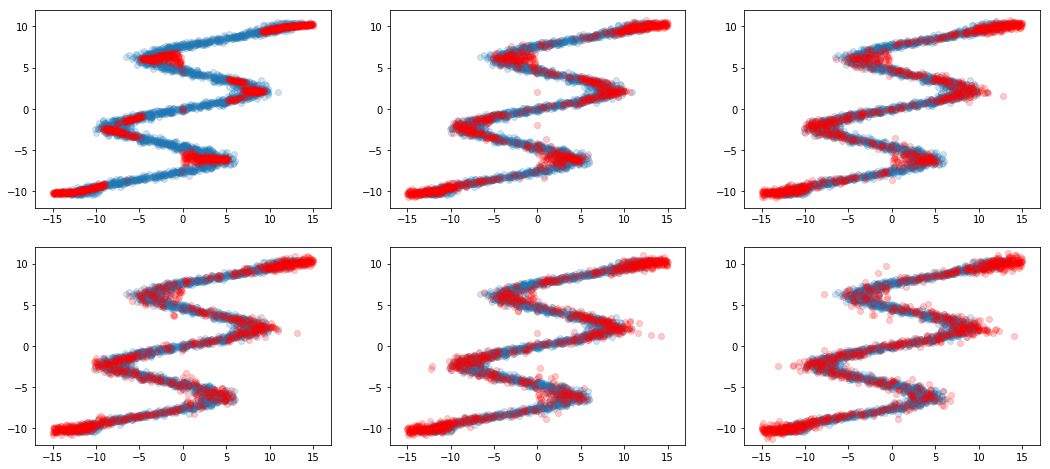

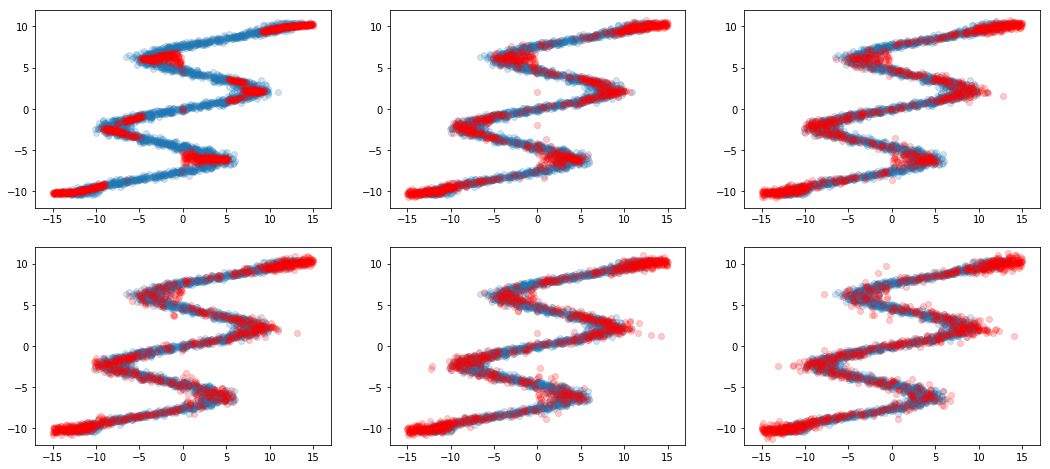

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6*3, 4*2))

list_tau = [0.1, 0.5, 0.8, 1.0, 1.2, 1.5]

test_data = torch.tensor(np.linspace(-15, 15, num=1000, dtype=np.float32), device=device).unsqueeze(1)
with torch.no_grad():  # disable gradient computation, save memory
    model.eval()  # evaluation mode
    
    log_pi, mu, std = model(test_data.to(device))

    for tau, ax in zip(list_tau, axes.reshape(-1)):
        samples = model.sample(log_pi=log_pi, mu=mu, std=std, tau=tau)
        samples.detach().cpu().numpy()

        ax.scatter(D.y, D.x, alpha=0.2)
        ax.scatter(test_data.detach().cpu().numpy(), samples.detach().cpu().numpy(), alpha=0.2, color='red')

        offset = 2
        ax.set_xlim(-15 - offset, 15 + offset)
        ax.set_ylim(-10 - offset, 10 + offset)
    
#fig.savefig('samples.png')
fig
#plt.figure(figsize=[6, 6])
#plt.scatter(D.y, D.x, alpha=0.2)
#plt.scatter(test_data.detach().cpu().numpy(), samples.detach().cpu().numpy(), alpha=0.2, color='red')
#plt.show()

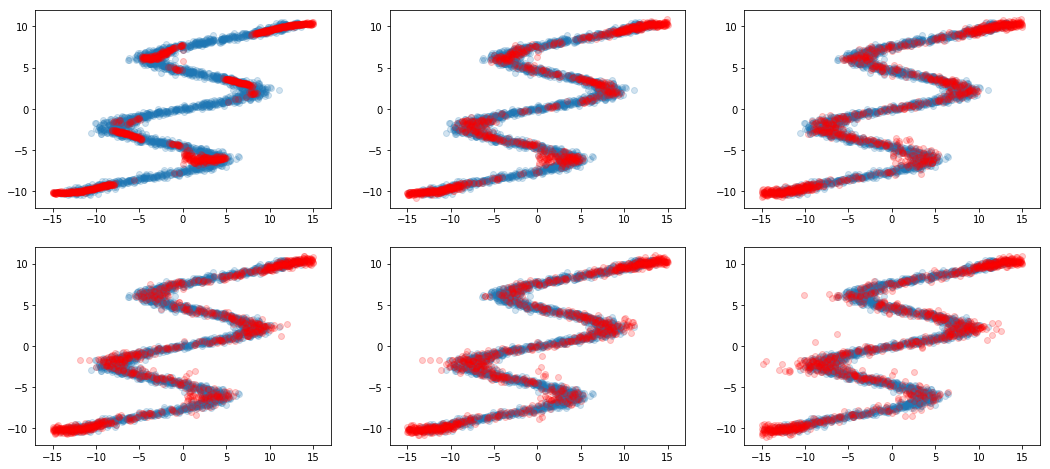

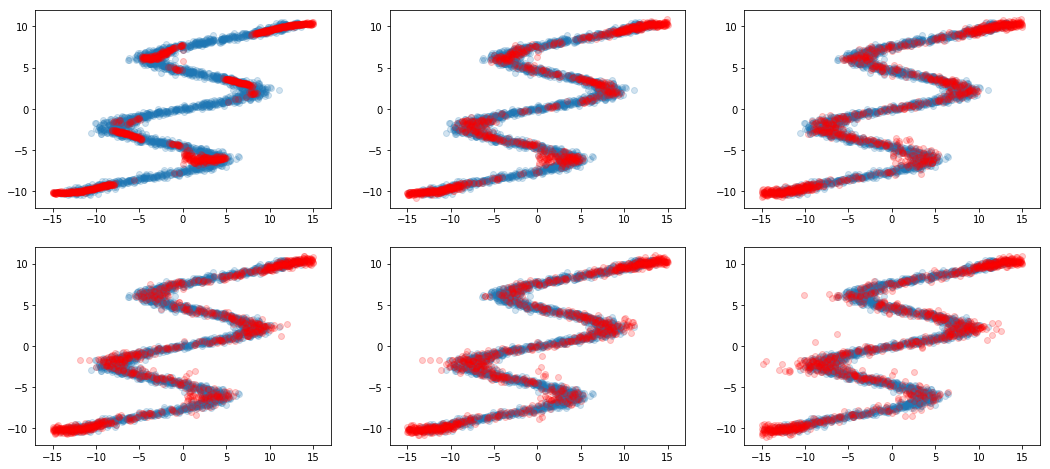

In [7]:
import matplotlib.pyplot as plt

test_data = torch.tensor(np.linspace(-15, 15, num=1000, dtype=np.float32), device=device).unsqueeze(1)
log_pi, mu, std = model(test_data.to(device))
samples = model.sample(log_pi=log_pi, mu=mu, std=std, tau=0.8)
samples.detach().cpu().numpy()

list_tau = [0.1, 0.5, 0.8, 1.0, 1.2, 1.5]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6*3, 4*2))

for tau, ax in zip(list_tau, axes.reshape(-1)):
    samples = model.sample(log_pi=log_pi, mu=mu, std=std, tau=tau)
    samples.detach().cpu().numpy()
    
    ax.scatter(D.y, D.x, alpha=0.2)
    ax.scatter(test_data.detach().cpu().numpy(), samples.detach().cpu().numpy(), alpha=0.2, color='red')
    
    offset = 2
    ax.set_xlim(-15 - offset, 15 + offset)
    ax.set_ylim(-10 - offset, 10 + offset)
    
fig.savefig('samples.png')
fig
#plt.figure(figsize=[6, 6])
#plt.scatter(D.y, D.x, alpha=0.2)
#plt.scatter(test_data.detach().cpu().numpy(), samples.detach().cpu().numpy(), alpha=0.2, color='red')
#plt.show()